In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os, sys
from scipy import interpolate
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.transforms as transforms
from datetime import datetime
from scipy import stats
import pickle, warnings

In [2]:
#sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/traj/"))
#sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/utilities/"))
sys.path.append(os.path.abspath("/xdisk/sylvia/tropic_vis/traj/"))
sys.path.append(os.path.abspath("/xdisk/sylvia/tropic_vis/utilities/"))
from traj_psd_obs import traj_psd
#from plotting_utilities import *
from plotting_utilities import sim_colors,rad2deg,sexy_axes
from densityPlot import *
from flighttrack import *
from thermodynamic_functions import *
from microphysical_functions import *

farbe = sim_colors()

In [3]:
warnings.filterwarnings( "ignore" )

# Figure 2: Domain topography and trajectory sample

In [5]:
# Domain topography map
file = '/xdisk/sylvia/scratch/extpar/extpar_icon-grid_tropic_55e170e5s40n_R2500m_bitmap.nc'
dset = xr.open_dataset(str(file))
x, y = dset['lon'].values, dset['lat'].values  # shape = (9648304,)

# Flight 7 track
#basedir = '/work/bb1018/b380873/tropic_vis/'
#scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
#sc_data = xr.open_dataset(scfi)
#lat_sc = sc_data['BEST:LAT'].values
#lon_sc = sc_data['BEST:LON'].values
#t_sc = sc_data['time'].values
#i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

In [7]:
# Read in a full 51-hour long trajectory file. Initialize empty arrays for altitude, latitude, longitude.
basedir = '/xdisk/sylvia/traj_output/traj_ICON_0V2M0A0R/'
pi = 3.141592653589793238
#os.environ["CARTOPY_USER_BACKGROUNDS"] = "/pf/b/b380873/conda-envs/ncplot/lib/python3.7/site-packages/cartopy/data/raster/natural_earth"
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/xdisk/sylvia/scratch/natural_earth"

# Below the file is just a sample one.
fi_name = basedir + 'traj_tst00000450_p011.nc'
timesteps = 7651
numtraj = xr.open_dataset(fi_name).dims['id']

traj_alt = np.zeros((timesteps,numtraj))
traj_lat = np.zeros((timesteps,numtraj))
traj_lon = np.zeros((timesteps,numtraj))

In [8]:
# Read in the altitude, longitude, latitude values
fi = xr.open_dataset(fi_name)
alt = fi.alt.values
lon = fi.lon.values
lat = fi.lat.values
t = fi.t.values
rtime = fi.rtime.values

# Find indices where the matrix != 0.
xs, ys = np.where(alt != 0)
# Extract the square with extreme limits.
# In limited testing, this seems always to generate [=] (88,5308)
alt = alt[:max(xs)+1,:max(ys)+1]
lon = lon[:max(xs)+1,:max(ys)+1]
lat = lat[:max(xs)+1,:max(ys)+1]
rtime = rtime[:max(xs)+1]

In [9]:
# Store the trimmed matrices.
temp1 = alt/1000.
temp2 = rad2deg(lat)
temp3 = rad2deg(lon)

# Mask the negative altitudes and fill values (-999.) for latitudes and longitudes.
traj_alt = np.where((temp1 > 0), temp1, np.nan)
traj_lat = np.where((temp2 >= -90.), temp2, np.nan)
traj_lon = np.where((temp3 >= -180.), temp3, np.nan)

<xarray.DataArray 'topography_c' ()>
array(8444.875)


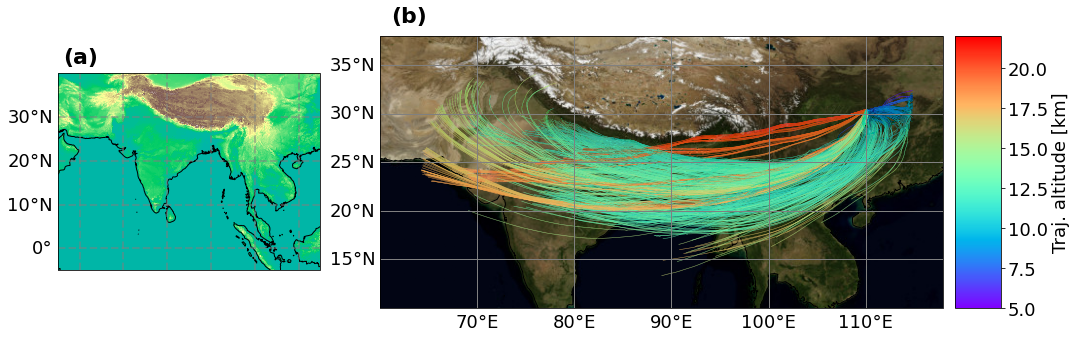

In [10]:
fs = 18
fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
print(dset['topography_c'].max())
ax0.coastlines()
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())
ax0.text(0.02,1.05,'(a)',weight='bold',fontsize=fs+4,transform=ax0.transAxes)

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs, 'rotation': 30}
gl.ylabel_style = {'size': fs}

## Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
## Create a set of line segments so that we can color them individually
#points = np.array([lon_sc[i_sc[:,0]],lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
#segments = np.concatenate([points[:-1],points[1:]],axis=1)

## Convert the times from np.datetime64 to float
#t_sc1 = t_sc[i_sc[:,0]]
#t_sc_f = t_sc1.astype("float")/1000000000.0
#t_sc_f = t_sc_f - np.nanmin(t_sc_f)
#norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
#lc = LineCollection(segments,cmap=cm.autumn,norm=norm)
#lc.set_array(t_sc_f)
#lc.set_linewidth(2)
#ax0.add_collection(lc)

ax1 = fig.add_subplot(gs[0,1:], projection=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='gray')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':fs}
gl.ylabel_style = {'size':fs}

ax1.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
ax1.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)

ax1.set_extent([60,118,10,38],crs=ccrs.PlateCarree()) # large domain
ax1.coastlines()
ax1.background_img(name='BM',resolution='high')
norm = plt.Normalize(5,22)

# How many trajectories to plot?
n = 700
for i in np.arange(n):
    # Create a set of line segments to color individually. Points in N x 1 x 2 array.
    points = np.array([traj_lon[:,i],traj_lat[:,i]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments,cmap='rainbow',norm=norm)
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(0.5)
    line = ax1.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap='rainbow',norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

def resize_colorbar(event):
    plt.draw()
    posn = ax1.get_position()
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                          0.04, posn.height])

fig.canvas.mpl_connect('resize_event', resize_colorbar)
c = plt.colorbar(sm, cax=cbar_ax)
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
resize_colorbar(None)
ax1.text(0.02,1.05,'(b)',weight='bold',fontsize=fs+4,transform=ax1.transAxes)

fig.savefig('/xdisk/sylvia/tropic_vis/output/topography-traj-noflighttrack.png',bbox_inches='tight')
plt.show()

# Figure 3: qi and Ni pdfs along the trajectories

In [6]:
#basedir = '/work/bb1018/b380873/traj_output/traj_pp/'
basedir = '/xdisk/sylvia/traj_output/traj_pp/hold/'
names = [ 'qih-Nih-CLAMS-Tf_0V1M0A0R.nc', 'qih-Nih-ICON_0V1M0A0R.nc', 
          'qih-Nih-CLAMS-Tf_0V2M0A0R.nc', 'qih-Nih-ICON_0V2M0A0R.nc',
          'qih-Nih-CLAMS_0V2M0A0R.nc', 'qih-Nih-CLAMS-Tf_0V2M0A0R_noSHflux.nc']
#names = [ 'qih-Nih-CLAMS-Tf_0V1M0A0R_first700.nc', 'qih-Nih-ICON_0V1M0A0R_first700.nc', 
#          'qih-Nih-CLAMS-Tf_0V2M0A0R_first700.nc', 'qih-Nih-ICON_0V2M0A0R_first700.nc',
#          'qih-Nih-CLAMS_0V2M0A0R_first700.nc', 'qih-Nih-CLAMS-Tf_0V2M0A0R_noSHflux_first700.nc']
datasets = []
for n in names:
    d = xr.open_dataset( basedir + n )
    datasets.append( d )

In [7]:
# Logarithmic IWC bins in ppmv, as well as their centerpoints
qi_bins = np.logspace( -5, 3, 50 )
qi_bins_c = ( qi_bins[1:] + qi_bins[:-1] )/2.

# Logarithmic Ni bins in L-1, as well as their centerpoints
Ni_bins = np.logspace( -4, 4, 50 )
Ni_bins_c = ( Ni_bins[1:] + Ni_bins[:-1] )/2.

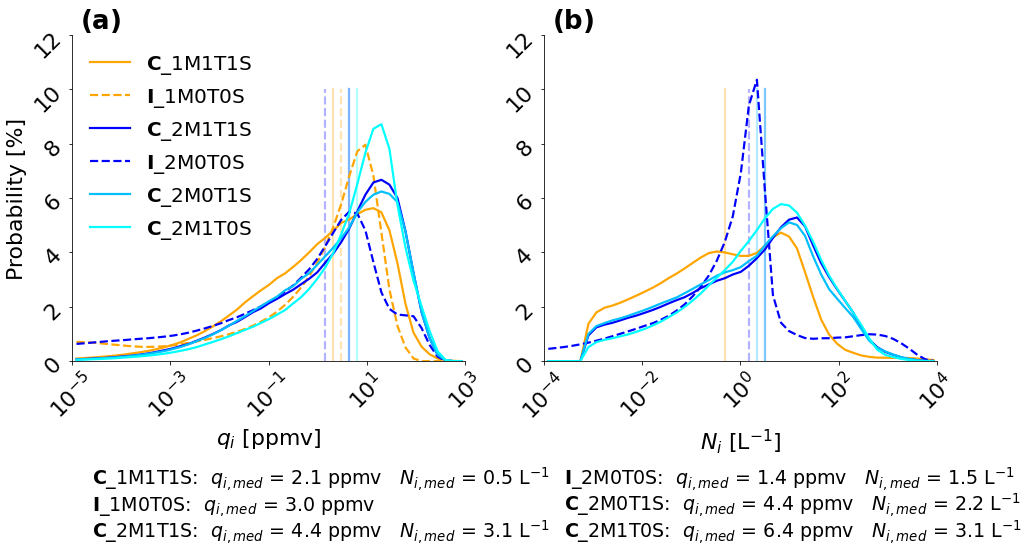

In [8]:
# Plot the histograms of qi and Ni for extracted trajectories
lw = 2.2
fs = 22
a1 = 1
a2 = 0.3
suffix = '_outflow' # '_insitu', '', '_flight'
#couleurs = [ 'orange', 'orange', 'blue', 'blue', 'blue', 'k' ]
#stil = [ '-', '--', '-', '--', ':', '-' ]
couleurs = [ 'orange', 'orange', 'blue', 'blue', 'deepskyblue', 'cyan' ]
stil = [ '-', '--', '-', '--', '-', '-' ]
lbls = [ r'$\bf{C}$' + '_1M1T1S', r'$\bf{I}$' + '_1M0T0S', r'$\bf{C}$' + '_2M1T1S',
         r'$\bf{I}$' + '_2M0T0S', r'$\bf{C}$' + '_2M0T1S', r'$\bf{C}$' + '_2M1T0S' ]

#fig, ax = plt.subplots( nrows=5, ncols=2, figsize=(15.5,6) )
fig = plt.figure( figsize=(15.5,6) )
gs = gridspec.GridSpec( 1, 2 )
# icon-only = [1:5:2]
for c, s, d, l, j in zip(couleurs, stil, datasets, lbls, np.arange(6)):
    ax1 = fig.add_subplot( gs[0,0] )
    ax1.plot( qi_bins_c, d['qih' + suffix], color=c, linestyle=s, linewidth=lw, label=l, alpha=a1 )
    #qim, qimed = centroids( 'qi' + suffix, j )
    #qim = np.asscalar( np.dot( qi_bins_c, d['qih' + suffix] )/np.sum( d['qih' + suffix] ) )
    qimed = np.asscalar( qi_bins_c[np.where( np.cumsum(d['qih' + suffix]) >= 50 )[0][0]] )
    ax1.plot( [qimed, qimed], [0, 10], color=c, linestyle=s, linewidth=lw, alpha=a2, zorder=0 )
    
    # The ICON one-moment simulation has no ice crystal number output.
    #if l != 'ICON-1M': 
    ax2 = fig.add_subplot( gs[0,1] )
    if j != 1:
        #Nim, Nimed = centroids( 'Ni' + suffix, j )
        #Nim = np.asscalar( np.dot( Ni_bins_c, d['Nih' + suffix] )/np.sum( d['Nih' + suffix] ) )
        Nimed = np.asscalar( Ni_bins_c[np.where( np.cumsum(d['Nih' + suffix]) >= 50 )[0][0]] )
        ax2.plot( [Nimed, Nimed], [0, 10], color=c, linestyle=s, linewidth=lw, alpha=a2, zorder=0 )
        ax2.plot( Ni_bins_c, d['Nih' + suffix], color=c, linestyle=s, linewidth=lw, alpha=a1 )
    
    if (j < 3) & (j != 1):
        ax1.text( 0.05, -0.38-j*0.08, l + r':  $q_{i,med}$ = ' + "{:.1f}".format(qimed) + ' ppmv   ' +
                 '$N_{i,med}$ = ' + "{:.1f}".format(Nimed) + r' L$^{-1}$', fontsize=fs-3, transform=ax1.transAxes )
    elif (j < 3) & (j == 1):
        ax1.text( 0.05, -0.38-j*0.08, l + r':  $q_{i,med}$ = ' + "{:.1f}".format(qimed) + ' ppmv   ',
                 fontsize=fs-3, transform=ax1.transAxes )
    elif (j >= 3):
        ax2.text( 0.05, -0.14-j*0.08, l + r':  $q_{i,med}$ = ' + "{:.1f}".format(qimed) + ' ppmv   ' +
                 '$N_{i,med}$ = ' + "{:.1f}".format(Nimed) + r' L$^{-1}$', fontsize=fs-3, transform=ax2.transAxes )
    
## Plot the StratoClim values if visualizing flight track period
#ax[0].plot( qi_bins_c, sc_qih, color='red', linestyle='-', linewidth=lw, label='Flight 7', alpha=a1 )
#ax[0].plot( [sc_qim, sc_qim], [0, 9], color='red', linestyle='-', linewidth=lw, alpha=a2, zorder=0 )
#ax[1].plot( Ni_bins_c, sc_Nih, color='red', linestyle='-', linewidth=lw, label='Flight 7', alpha=a1 )
#ax[1].plot( [sc_Nim, sc_Nim], [0, 9], color='red', linestyle='-', linewidth=lw, alpha=a2, zorder=0 )
##

ax1.set_xlim([qi_bins[0], qi_bins[-1]])
ax1.set_ylim([0,12])
ax1.set_xscale('log')
ax1.text(0.02, 1.02, r'$\bf{(a)}$', fontsize=fs+4, transform=ax1.transAxes)
ax1.set_xlabel( r'$q_i$ [ppmv]', fontsize=fs )
ax1.set_ylabel( 'Probability [%]', fontsize=fs )
l = ax1.legend( loc='upper left', fontsize=fs-2, frameon=False )
sexy_axes( ax1, fs )

ax2.set_xlim([Ni_bins[0], Ni_bins[-1]])    
ax2.set_ylim([0,12])
ax2.set_xscale('log')
ax2.text(0.02, 1.02, r'$\bf{(b)}$', fontsize=fs+4, transform=ax2.transAxes)
ax2.set_xlabel( r'$N_i$ [L$^{-1}$]', fontsize=fs )
sexy_axes( ax2, fs )

#fig.savefig( '/xdisk/sylvia/tropic_vis/output/CLaMS-ICON-qi-Ni-pdfs' + suffix + '.pdf',bbox_inches='tight' )
plt.show()

# Figure 4: qi and Ni process pdfs from CLaMS

In [9]:
#basedir = '/work/bb1018/b380873/traj_output/traj_pp/'
basedir = '/xdisk/sylvia/traj_output/traj_pp/'
names = [ 'het-hom-pre-CLAMS-Tf_0V1M0A0R.nc',
          'het-hom-pre-CLAMS-Tf_0V2M0A0R.nc' ]
datasets = []
for n in names:
    d = xr.open_dataset( basedir + n )
    datasets.append( d )

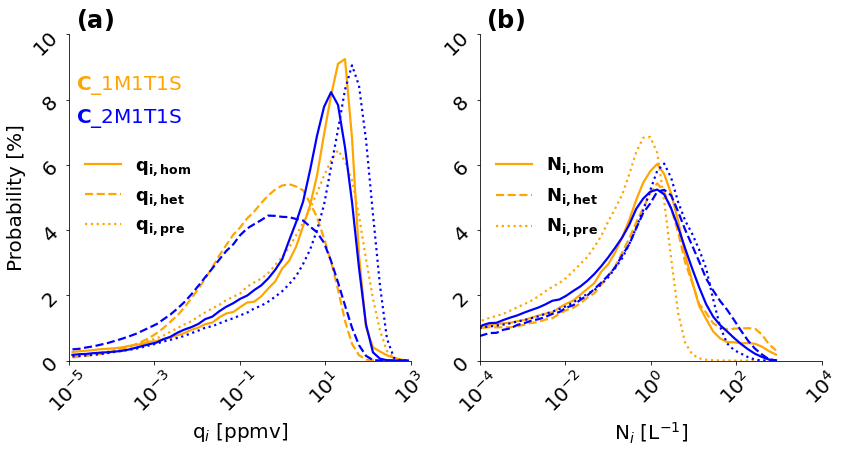

In [11]:
# Plot the histograms of CLaMS processes
lw = 2.2
fs = 20
a = 1 # 0.5
suffix = '' # '_outflow', '_insitu', '_flight'
couleurs = [ 'orange', 'blue' ]
lbls = [ [r'$\bf{q_{i,hom}}$', r'$\bf{q_{i,het}}$', r'$\bf{q_{i,pre}}$', r'$\bf{N_{i,hom}}$', r'$\bf{N_{i,het}}$', r'$\bf{N_{i,pre}}$' ],
          ['', '', '', '', '', '', '' ] ]

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(13.5,6) )
for c, s, d, l, j in zip(couleurs, stil, datasets, lbls, np.arange(2)):
    ax[0].plot( qi_bins_c, d['qhomih'], color=c, linestyle='-', linewidth=lw, label=l[0], alpha=a )
    ax[0].plot( qi_bins_c, d['qhetih'], color=c, linestyle='--', linewidth=lw, label=l[1], alpha=a )
    ax[0].plot( qi_bins_c, d['qpreih'], color=c, linestyle=':', linewidth=lw, label=l[2], alpha=a )
    
    ax[1].plot( qi_bins_c, d['Nhomih'], color=c, linestyle='-', linewidth=lw, label=l[3], alpha=a )
    ax[1].plot( qi_bins_c, d['Nhetih'], color=c, linestyle='--', linewidth=lw, label=l[4], alpha=a )
    ax[1].plot( qi_bins_c, d['Npreih'], color=c, linestyle=':', linewidth=lw, label=l[5], alpha=a )
    
ax[0].text( 0.02, 0.83, r'$\bf{C}$' + '_1M1T1S', color='orange', fontsize=fs, transform=ax[0].transAxes )
ax[0].text( 0.02, 0.73, r'$\bf{C}$' + '_2M1T1S', color='blue', fontsize=fs, transform=ax[0].transAxes )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
l = ax[0].legend( loc='center left', fontsize=fs-2, frameon=False )
ax[0].set_xscale('log')
ax[0].set_xlim([qi_bins[0], qi_bins[-1]])    
ax[0].set_ylim([0,10])
ax[0].text(0.02, 1.02, r'$\bf{(a)}$', fontsize=fs+4, transform=ax[0].transAxes)
ax[0].set_xlabel( r'q$_i$ [ppmv]', fontsize=fs )
sexy_axes( ax[0], fs )

ax[1].set_xscale('log')
ax[1].set_xlim([Ni_bins[0], 10**4])    
ax[1].set_ylim([0,10])
l = ax[1].legend( loc='center left', fontsize=fs-2, frameon=False )
ax[1].text(0.02, 1.02, r'$\bf{(b)}$', fontsize=fs+4, transform=ax[1].transAxes)
ax[1].set_xlabel( r'N$_i$ [L$^{-1}$]', fontsize=fs )
sexy_axes( ax[1], fs )

fig.savefig( '/xdisk/sylvia/tropic_vis/output/CLaMS-qi-Ni-process-pdfs' + suffix + '.pdf',bbox_inches='tight' )
plt.show()

# Figure 5: Time-dependent qi difference distributions

In [5]:
#basedir = '/work/bb1018/b380873/traj_output/traj_pp/'
basedir = '/xdisk/sylvia/traj_output/traj_pp/'
# We also have these differences along a normalized time axis but we only use the absolute axis here
qia_1M = np.load( basedir + 'qi_abs_diff_1M.npy' )
qia_2M = np.load( basedir + 'qi_abs_diff_2M.npy' )
qia_ppmv_1M = np.load( basedir + 'qi_ppmv_abs_diff_1M.npy' )
qia_ppmv_2M = np.load( basedir + 'qi_ppmv_abs_diff_2M.npy' )

In [6]:
# Count how many trajectories hit a certain qi difference along the normalized lifetime
qb = 50
qi_ppmv_diff_bins_1M = np.linspace( -100, 100, qb )
qi_ppmv_diff_bins_2M = np.linspace( -200, 200, qb )
qia1M_ppmv_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_ppmv_diff_bins_1M)[0], axis=0, arr=qia_ppmv_1M )
qia2M_ppmv_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_ppmv_diff_bins_2M)[0], axis=0, arr=qia_ppmv_2M )
qi_diff_bins_1M = np.linspace( -100, 100, qb )
qi_diff_bins_2M = np.linspace( -200, 200, qb )
qia1M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins_1M)[0], axis=0, arr=qia_1M )
qia2M_diff_hist = np.apply_along_axis( lambda a: np.histogram(a, bins=qi_diff_bins_2M)[0], axis=0, arr=qia_2M )

In [7]:
lbls = [ r'$\bf{I}$_1M0T0S - $\bf{C}$_1M1T1S' + '\n' + '$\Delta q_i$ [ppmv]',
         r'$\bf{I}$_2M0T0S - $\bf{C}$_2M1T1S' + '\n' + '$\Delta q_i$ [ppmv]' ]
let = [ '(a)', '(b)', '(c)', '(d)' ]

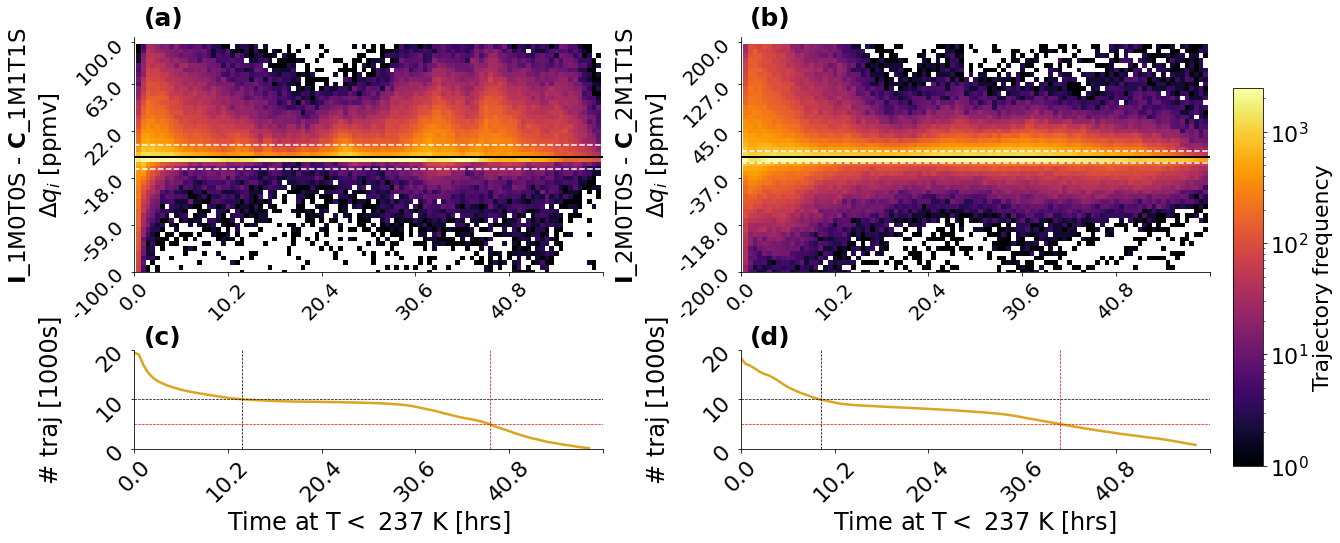

In [10]:
fs = 22
fig = plt.figure( figsize=(17,7.5) )
gs = fig.add_gridspec(3,2)
for q, x, j in zip([ qia1M_ppmv_diff_hist, qia2M_ppmv_diff_hist ], [ qia1M_diff_hist, qia2M_diff_hist ], np.arange(2)):
    a = fig.add_subplot(gs[:2,j])
    im = a.imshow( q, aspect=1, cmap=cm.inferno, origin='lower', norm=colors.LogNorm(vmin=1, vmax=2500) )
    
    if j == 0:
        ytic_vals = [ round(qi_diff_bins_1M[x]) for x in [0, int(qb/5), int(2*qb/5), int(3*qb/5), int(4*qb/5), qb-1] ]
        k = np.argmin( np.abs(qi_diff_bins_1M) )
        k1 = -qi_diff_bins_1M[k]/(qi_diff_bins_1M[k+1]-qi_diff_bins_1M[k])+k
        a.plot( [0, 100], [k1, k1], color='k', linestyle='-', lw=2 )
        k = np.argmin( np.abs(qi_diff_bins_1M-10) )
        k1 = (10-qi_diff_bins_1M[k])/(qi_diff_bins_1M[k+1]-qi_diff_bins_1M[k])+k
        a.plot( [0, 100], [k1, k1], color='w', linestyle='--', lw=1.5 )
        k = np.argmin( np.abs(qi_diff_bins_1M+10) )
        k1 = (-10-qi_diff_bins_1M[k])/(qi_diff_bins_1M[k+1]-qi_diff_bins_1M[k])+k
        a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
    else:
        ytic_vals = [ round(qi_diff_bins_2M[x]) for x in [0, int(qb/5), int(2*qb/5), int(3*qb/5), int(4*qb/5), qb-1] ]
        k = np.argmin( np.abs(qi_diff_bins_2M) )
        k1 = -qi_diff_bins_2M[k]/(qi_diff_bins_2M[k+1]-qi_diff_bins_2M[k])+k
        a.plot( [0, 100], [k1, k1], color='k', linestyle='-', lw=2 )
        k = np.argmin( np.abs(qi_diff_bins_2M-10) )
        k1 = (10-qi_diff_bins_2M[k])/(qi_diff_bins_2M[k+1]-qi_diff_bins_2M[k])+k
        a.plot( [0, 100], [k1, k1], color='w', linestyle='--', lw=1.5 )
        k = np.argmin( np.abs(qi_diff_bins_2M+10) )
        k1 = (-10-qi_diff_bins_2M[k])/(qi_diff_bins_2M[k+1]-qi_diff_bins_2M[k])+k
        a.plot( [0, 100], [k1, k1], color='w', linestyle='--', lw=1.5 )
    
    a.set_yticks( [0, int(qb/5), int(2*qb/5), int(3*qb/5), int(4*qb/5), qb-1] )
    a.set_yticklabels( ytic_vals )
    a.set_xticks( [0, 20, 40, 60, 80, 100] )
    a.set_xlim( [0, 100] )
    a.set_ylim( [0, qb] )
    xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
    a.set_xticklabels( xtic_vals )
    sexy_axes( a, fs=fs-2 ) 
    a.text( 0.02, 1.05, let[j], fontsize=fs+3, weight='bold', color='k', transform=a.transAxes )
    a.set_ylabel( lbls[j], fontsize=fs+1 )

    a = fig.add_subplot(gs[2,j])
    s = np.sum(x, axis=0)[2:]/1000
    a.plot( s, 'goldenrod', lw=2.5 ) 
    a.plot( [0, 100], [10, 10], 'k', ls='--', lw=0.7 )
    k = np.argmin( np.abs(s-10) )
    a.plot( [k, k], [0, 20], 'k', ls='--', lw=0.7 )
    a.plot( [0, 100], [5, 5], 'r', ls='--', lw=0.7 )
    k = np.argmin( np.abs(s-5) )
    a.plot( [k, k], [0, 20], 'r', ls='--', lw=0.7 )
    sexy_axes( a, fs=fs )
    a.set_ylim( [0, 20])
    a.set_xlim( [0, 100] )
    a.set_ylabel( '# traj [1000s]', fontsize=fs+2, labelpad=30 )
    a.set_xticks( [0, 20, 40, 60, 80, 100] )
    a.set_xticklabels( xtic_vals )
    a.set_xlabel( r'Time at T$<$ 237 K [hrs]', fontsize=fs+2 )
    a.text( 0.02, 1.05, let[j+2], fontsize=fs+3, weight='bold', color='k', transform=a.transAxes )

cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cb = plt.colorbar( im, cax=cbar_ax )
cb.set_label( r'Trajectory frequency', fontsize=fs )
cb.ax.tick_params( labelsize=fs )

plt.tight_layout()
fig.savefig( '/xdisk/sylvia/tropic_vis/output/CLaMS-ICON-qi-lifetime-diff.pdf', bbox_inches='tight' )
plt.show()

# Figure 6: Time-dependent Ni difference distribution and correlation of qi and Ni differences

In [28]:
#basedir = '/work/bb1018/b380873/traj_output/traj_pp/'
basedir = '/xdisk/sylvia/traj_output/traj_pp/'
Nia_2M = np.load( basedir + 'Ni_abs_diff_2M.npy' )

Ni_diff_bins_2M = np.concatenate((-1*np.logspace( 3, 1, 25), np.logspace( 1, 3, 25 )), axis=0)
Nb = Ni_diff_bins_2M.shape[0]
Nia2M_diff_hist = 2*np.apply_along_axis( lambda a: np.histogram(a, bins=Ni_diff_bins_2M)[0], axis=0, arr=Nia_2M )

In [29]:
qia_2M = np.load( basedir + 'qi_abs_diff_2M.npy' )
abs_2M = np.stack( (qia_2M.flatten(), Nia_2M.flatten()), axis=1 )
print( abs_2M.shape )

# Identify where either the Ni diff or the qi diff is nan and throw out
# these samples.
out = np.any( np.isnan(abs_2M), axis=1 )
i = np.argwhere( (np.array(out) == False) )[:,0]
abs_2M = abs_2M[i]
print( abs_2M.shape )

(2773800, 2)
(375066, 2)


In [30]:
qb = 50
qi_diff_bins_2M = np.linspace( -200, 200, qb )  #-50, 50
#Ni_diff_bins_2M = np.linspace( -50, 50, 50 ) #-300, 300
h_qivNi, _, _ = np.histogram2d( x=abs_2M[:,0], y=abs_2M[:,1], bins=[qi_diff_bins_2M, Ni_diff_bins_2M] )

In [31]:
indx_quadI = np.argwhere( (abs_2M[:,0] > 0) & (abs_2M[:,1] > 0) )[:,0]
#abs_2M[:, [0, 1]] = abs_2M[:, [1, 0]]
res = stats.linregress( np.log10(abs_2M[indx_quadI,1]), abs_2M[indx_quadI,0] )
print(abs_2M[indx_quadI].shape )
print( 'r2 and slope of linear fit to +Delta qi/+Delta Ni (ICON larger): ' +
       str(res.rvalue) + ' ' + str(res.slope) )

indx_quadIII = np.argwhere( (abs_2M[:,0] < 0) & (abs_2M[:,1] < 0) )[:,0]
res = stats.linregress( np.log10(-1*abs_2M[indx_quadIII,1]), -1*abs_2M[indx_quadIII,0] )
print( 'r2 and slope of linear fit to -Delta qi/-Delta Ni (CLaMS larger): ' +
       str(res.rvalue) + ' ' + str(res.slope) )

(221659, 2)
r2 and slope of linear fit to +Delta qi/+Delta Ni (ICON larger): 0.6345860407106488 33.29814089454396
r2 and slope of linear fit to -Delta qi/-Delta Ni (CLaMS larger): 0.47120573599277427 9.16342068516904


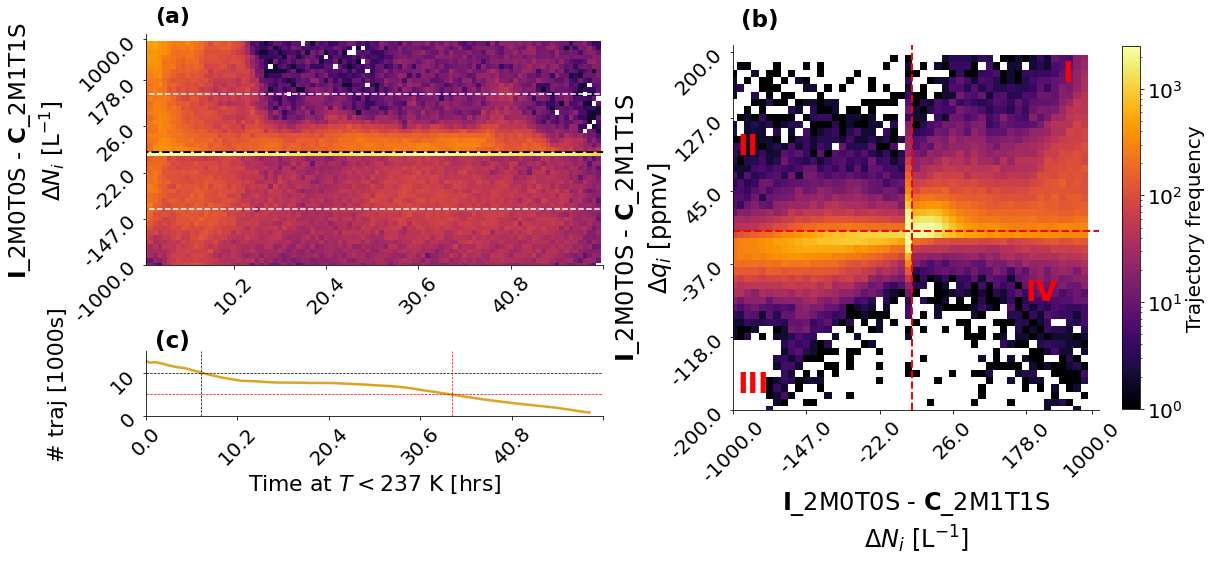

In [34]:
fs = 20
fig = plt.figure( figsize=(17,7.5) )
gs = fig.add_gridspec(3,2)

a = fig.add_subplot(gs[:2,0])
h = a.imshow( Nia2M_diff_hist, aspect=1, origin='lower', cmap=cm.inferno,
           norm=colors.LogNorm(vmin=1, vmax=2500) )
a.set_yticks( [0, 10, 20, 30, 40, 49] )
ytic_vals = [ round(Ni_diff_bins_2M[x]) for x in [0, 10, 20, 30, 40, 49] ]
k = np.argmin( np.abs(Ni_diff_bins_2M) )
k1 = -Ni_diff_bins_2M[k]/(Ni_diff_bins_2M[k+1]-Ni_diff_bins_2M[k])+k
a.plot( [0, 100], [k1, k1], color='k', linestyle='--', lw=2 )
k = np.argmin( np.abs(Ni_diff_bins_2M-100) )
a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
k = np.argmin( np.abs(Ni_diff_bins_2M+100) )
a.plot( [0, 100], [k, k], color='w', linestyle='--', lw=1.5 )
a.set_yticklabels( ytic_vals )
a.set_xticks( [0, 20, 40, 60, 80, 100] )
a.set_xlim( [1, 100] )
a.set_ylim( [0, 50] )
xtic_vals = [round(x * 7651 * 24 / 3600., 1) for x in [0, 0.2, 0.4, 0.6, 0.8] ]
a.set_xticklabels( xtic_vals )
sexy_axes( a, fs=fs ) 
a.text( 0.02, 1.05, '(a)', fontsize=fs+2, weight='bold', transform=a.transAxes, color='k' )
a.set_ylabel( r'$\bf{I}$_2M0T0S - $\bf{C}$_2M1T1S' + '\n' + '$\Delta N_i$ [L$^{-1}$]', fontsize=fs+3 )

a = fig.add_subplot(gs[2,0])
s = np.sum(qia2M_diff_hist, axis=0)[2:]/1000
a.plot( s, 'goldenrod', lw=2.5 ) 
a.plot( [0, 100], [10, 10], 'k', ls='--', lw=0.7 )
k = np.argmin( np.abs(s-10) )
a.plot( [k, k], [0, 15], 'k', ls='--', lw=0.7 )
a.plot( [0, 100], [5, 5], 'r', ls='--', lw=0.7 )
k = np.argmin( np.abs(s-5) )
a.plot( [k, k], [0, 15], 'r', ls='--', lw=0.7 )
sexy_axes( a, fs=fs )
a.set_ylim( [0, 15])
a.set_xlim( [1, 100] )
a.set_ylabel( '# traj [1000s]', fontsize=fs+2, labelpad=40 )
a.set_xticks( [0, 20, 40, 60, 80, 100] )
a.set_xticklabels( xtic_vals )
a.set_xlabel( r'Time at $T<$237 K [hrs]', fontsize=fs+2 )
a.text( 0.02, 1.05, '(c)', fontsize=fs+3, weight='bold', color='k', transform=a.transAxes )
a.set_aspect(0.95)

a = fig.add_subplot(gs[:,1])
plt.imshow( h_qivNi, cmap=cm.inferno, norm=colors.LogNorm(vmin=1,vmax=2500), origin='lower')
ytic_vals = [ round(qi_diff_bins_2M[x]) for x in [0, int(qb/5), int(2*qb/5), int(3*qb/5), int(4*qb/5), qb-1] ]
xtic_vals = [ round(Ni_diff_bins_2M[x]) for x in [0, int(Nb/5), int(2*Nb/5), int(3*Nb/5), int(4*Nb/5), Nb-1] ]

# Interpolate to draw a line where zero is.
k = np.argmin( np.abs(qi_diff_bins_2M) )
yzero = -qi_diff_bins_2M[k]/(qi_diff_bins_2M[k+1]-qi_diff_bins_2M[k])+k
plt.plot( [0, Nb], [yzero, yzero], color='r', ls='--', lw=2 )
k = np.argmin( np.abs(Ni_diff_bins_2M) )
xzero = -Ni_diff_bins_2M[k]/(Ni_diff_bins_2M[k+1]-Ni_diff_bins_2M[k])+k
plt.plot( [xzero, xzero], [0, qb], color='r', ls='--', lw=2 )

a.set_yticks( [0, int(qb/5), int(2*qb/5), int(3*qb/5), int(4*qb/5), qb-1] )
a.set_yticklabels( ytic_vals, fontsize=fs, rotation=45 )
a.set_ylabel( r'$\bf{I}$_2M0T0S - $\bf{C}$_2M1T1S' + '\n' + r'$\Delta q_i$ [ppmv]', fontsize=fs+4, labelpad=-7 )
a.set_xticks( [0, int(Nb/5), int(2*Nb/5), int(3*Nb/5), int(4*Nb/5), Nb-1] )
a.set_xticklabels( xtic_vals, fontsize=fs, rotation=45 )
a.set_xlabel( r'$\bf{I}$_2M0T0S - $\bf{C}$_2M1T1S' + '\n' + r'$\Delta N_i$ [L$^{-1}$]', fontsize=fs+4 )
a.spines['right'].set_color('none')
a.spines['top'].set_color('none')
a.set_xlim([0, Nb])
a.set_ylim([0, qb])
a.text( 0.02, 1.05, '(b)', fontsize=fs+3, weight='bold', color='k', transform=a.transAxes )
a.text( 0.9, 0.9, 'I', fontsize=fs+8, weight='bold', color='r', transform=a.transAxes )
a.text( 0.01, 0.7, 'II', fontsize=fs+8, weight='bold', color='r', transform=a.transAxes )
a.text( 0.01, 0.05, 'III', fontsize=fs+8, weight='bold', color='r', transform=a.transAxes )
a.text( 0.8, 0.3, 'IV', fontsize=fs+8, weight='bold', color='r', transform=a.transAxes )

cb = plt.colorbar( shrink=0.9 )
cb.set_label( 'Trajectory frequency', fontsize=fs )
cb.ax.tick_params( labelsize=fs )

plt.tight_layout()
fig.savefig( '/xdisk/sylvia/tropic_vis/output/CLaMS-ICON-Ni-lifetime-diff.pdf', bbox_inches='tight' )
plt.show()

# Figure 7: qi-T density for the different trajectories

In [5]:
#basedir = '/work/bb1018/b380873/traj_output/traj_pp/'
#basedir2 = '/work/bb1018/b380873/tropic_vis/obs/'
basedir = '/xdisk/sylvia/traj_output/traj_pp/'
basedir2 = '/xdisk/sylvia/tropic_vis/obs/'

names = [ 'qippmvNi-TRHi-2Dh-CLAMS-Tf_0V1M0A0R.nc', 'qippmvNi-TRHi-2Dh-ICON_0V1M0A0R.nc',
          'qippmvNi-TRHi-2Dh-CLAMS-Tf_0V2M0A0R.nc', 'qippmvNi-TRHi-2Dh-ICON_0V2M0A0R.nc']#,
          #'qippmvNi-TRHi-2Dh-CLAMS_0V2M0A0R.nc', 'stratoclim2017.geophysika.0808_1_hist.nc' ]
bd = [ basedir ] * 5 #+ [ basedir2 ]

datasets = []
for n, b in zip(names, bd):
    d = xr.open_dataset( b + n )
    datasets.append( d )

figsave


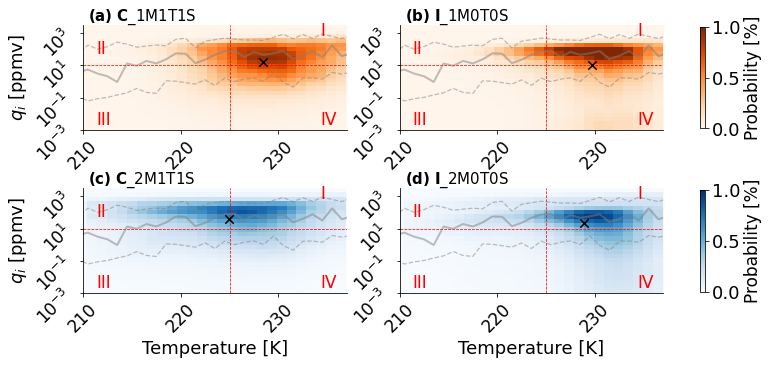

In [15]:
densityPlot( datasets, 'qiTh_outflow', 'T', 210, 237, 'qi', tiwc_line=True, centroid=1, figsave=True )

# Figure 8: qi-RHi density for the different trajectories

figsave


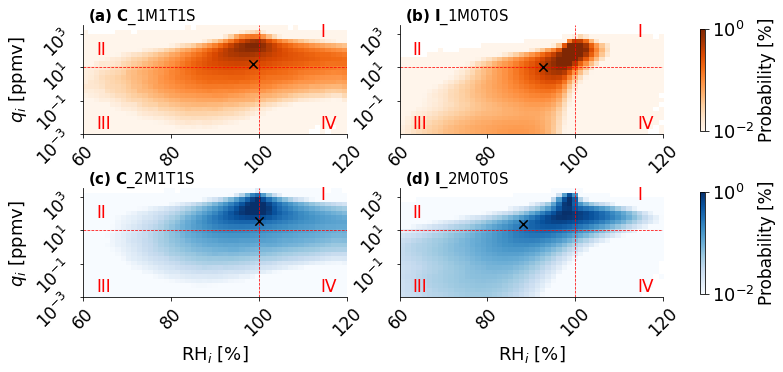

In [7]:
densityPlot( datasets, 'qiRHih_outflow', 'RHi', 60, 120, 'qi', tiwc_line=False, centroid=1, figsave=True )

# Figure 9: Microphysical variables

1.5264179671752365


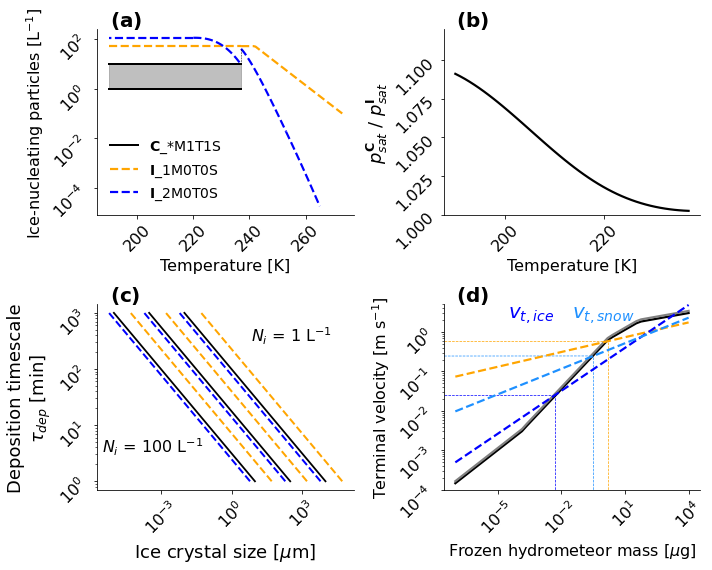

In [36]:
Tmin = 190
Thom = 237
Tmax = 273
bins = 50
fs = 16

T_cirr = np.linspace( Tmin, Thom, bins )
T_dep = np.linspace( 220, 237, bins )
T_both = np.linspace( 237, 253, bins )
T_imm = np.linspace( 253, 265, bins )
T_mp = np.linspace( Thom, Tmax, bins )
Nfletcher_cirr = 100/1000*np.exp( -0.2*(T_cirr - Tmax) ) # Divide the prefactor by 1000 for [L-1]
Nfletcher_mp = 100/1000*np.exp( -0.2*(T_mp - Tmax) )

Aimm = 2.9694*10**4/1000  # Divide the prefactor by 1000 for [L-1]
Bimm = 0.2813
Cimm = 1.1778
Nhande_imm = Aimm*np.exp( -Bimm*(T_imm - Thom)**Cimm )

Adep = 2.6543*10**4/1000  # Divide the prefactor by 1000 for [L-1]
Bdep = 0.002
Cdep = 2.5128
a = 2.7626
b = 0.0621
c = -1.3107
d = 2.6789
RHice = 130
DSF = a * np.arctan(b * (RHice-100) + c) + d
Nhande_dep = Adep*np.exp( -Bdep*(T_dep - 220)**Cdep )*DSF
Nhande_both = Adep*np.exp( -Bdep*(T_both - 220)**Cdep )*DSF + Aimm*np.exp( -Bimm*(T_both - Thom)**Cimm )


fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(10,8) )
#ax[0,0].plot( [Thom, Tmin], [10, 10], c='blue', ls='-', lw=5, label='C_1M0T0S' )
ax[0,0].plot( [Thom, Tmin], [10, 10], c='black', ls='-', lw=2, label=r'$\bf{C}$_*M1T1S' )
ax[0,0].plot( [Thom, Tmin], [1, 1], c='black', ls='-', lw=2 )
ax[0,0].fill_between( [Thom, Tmin], [1, 1], [10, 10], color='gray', alpha=0.5 )

ax[0,0].plot( T_mp, [min(n,50) for n in Nfletcher_mp], c='orange', ls='--', lw=2.2 )
ax[0,0].plot( T_imm, Nhande_imm, c='blue', ls='--', lw=2.2 )
ax[0,0].plot( T_both, Nhande_both, c='blue', ls='--', lw=2.2 )
#ax[0,0].plot( [Thom, Thom], [Nfletcher_mp[0], 10], c='k', ls='--', lw=0.5 )
ax[0,0].plot( [Thom, Thom], [Nhande_both[0], 10], c='k', ls='--', lw=0.5 )

ax[0,0].plot( T_cirr, [min(n,50) for n in Nfletcher_cirr], c='orange', ls='--', lw=2.2, label=r'$\bf{I}$_1M0T0S' )
ax[0,0].plot( T_dep, Nhande_dep, c='blue', ls='--', lw=2.2, label=r'$\bf{I}$_2M0T0S' )
ax[0,0].plot( [220, Tmin], [Nhande_dep[0], Nhande_dep[0]], c='blue', ls='--', lw=2.2 )
ax[0,0].set_yscale( 'log' )
#ax[0,0].invert_xaxis()
ax[0,0].legend( loc='lower left', fontsize=fs-2, frameon=False )
ax[0,0].text( 0.05, 1.02, r'$\bf{(a)}$', fontsize=fs+4, weight='bold', transform=ax[0,0].transAxes )
ax[0,0].set_xlabel( 'Temperature [K]', fontsize=fs )
ax[0,0].set_ylabel( 'Ice-nucleating particles [L$^{-1}$]', fontsize=fs )
sexy_axes( ax[0,0], fs )

T = np.linspace( Tmin, Thom, bins )
a = 54.842763
b = 6763.22
c = 4.210
d = 0.000367
e = 0.0415
f = 218.8
g = 53.878
h = 1331.22
i = 9.44523
j = 0.014025
factor = g - h/T - i*np.log(T) + j*T
psat_MK = a - b/T - c*np.log(T) + d*T + np.arctan(e*(T-f))*factor
psat_MK = np.exp( psat_MK )

a = 74.8727
b = 7167.40548
c = 7.77107
d = 0.00505
psat_Nachbar = np.exp( a - b/T - c*np.log(T) + d*T )
ax[0,1].plot( T, psat_Nachbar/psat_MK, lw=2.2, c='k' )
ax[0,1].set_ylabel( r'$p_{sat}^{\bf{C}}$ / $p_{sat}^{\bf{I}}$', fontsize=fs+2 )
ax[0,1].set_xlabel( 'Temperature [K]', fontsize=fs )
ax[0,1].set_ylim( [1, 1.12])
ax[0,1].text( 0.05, 1.02, r'$\bf{(b)}$', fontsize=fs+4, weight='bold', transform=ax[0,1].transAxes )
sexy_axes( ax[0,1], fs )

T = 230
p = 25000
Ni = np.tile(np.logspace( 0, 3, 3 ),[100,1])
ri = np.tile(np.logspace( 0, 3, 100 ),[3,1]).T
Rv = 461.5 # water vapor specific gas constant [J kg-1 K-1]
rho_air = 1.395   # density of air (assumed - 15 C) [kg m-3]
Hi = diffusivity_icon(T,p)*heatSub(T)**2/(kAir(T)*Rv*T**2)*rho_air*satMR_ice(T)
# Factor of 2 below is the capacitance in the ICON 2-mom scheme
# Divide ri by 10^6 for um to m and multiply Ni by 10^3 for L-1 to m-3
tau_dep_icon2m = (1 + Hi)/(8*(2*ri)*np.pi*diffusivity_icon(T,p)*ri/10**6*Ni*10**3)

Hi = 2.22*10**(-5)*heatSub(T)**2/(kAir(T)*Rv*T**2)*rho_air*satMR_ice(T)
tau_dep_icon1m = (1 + Hi)/(8*(2*ri)*2.22*10**(-5)*ri/10**6*Ni*10**3)
i = np.argmin(np.abs(ri[:,0]-50))
#print(tau_dep_icon1m[i,1])
#print(tau_dep_icon2m[i,1])
#print(tau_dep_clams[i,1])
#print(tau_dep_clams[i,0])

Hi = diffusivity_clams(T,p)*heatSub(T)**2/(kAir(T)*Rv*T**2)*rho_air*satMR_ice(T)
tau_dep_clams = (1 + Hi)/(8*capacitance(ri,2)*np.pi*diffusivity_clams(T,p)*ri/10**6*Ni*10**3)
ax[1,0].plot( tau_dep_clams/60, ri, ls='-', lw=1.8, color='black' )
ax[1,0].plot( tau_dep_icon1m/60, ri, ls='--', lw=2, color='orange' )
ax[1,0].plot( tau_dep_icon2m/60, ri, ls='--', lw=2, color='blue' )
ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')
#ax[1,0].set_xlim([10**(-1), 10**5])
ax[1,0].set_xlabel( r'Ice crystal size [$\mu$m]', fontsize=fs+2 )
ax[1,0].set_ylabel( r'Deposition timescale' + '\n' + r'$\tau_{dep}$ [min]', fontsize=fs+2 )
ax[1,0].text( 0.05, 1.02, r'$\bf{(c)}$', fontsize=fs+4, weight='bold', transform=ax[1,0].transAxes )
ax[1,0].text( 0.02, 0.2, r'$N_i$ = 100 L$^{-1}$', fontsize=fs, transform=ax[1,0].transAxes )
ax[1,0].text( 0.6, 0.8, r'$N_i$ = 1 L$^{-1}$', fontsize=fs, transform=ax[1,0].transAxes )
sexy_axes( ax[1,0], fs )

m = np.logspace( -16, -5, 50 )
vt_clams = [terminalVelocity_clams(mm, T=237, p=23200) for mm in m]
vt_clams2 = [terminalVelocity_clams(mm, T=190, p=19000) for mm in m]
vt_icon1m = [terminalVelocity_icon1m(mm) for mm in m]
vt_icon2m = np.array( [terminalVelocity_icon2m(mm, rho=1.225) for mm in m] )
lw = 0.7
k = np.argmin( np.abs([v1-v2 for v1,v2 in zip(vt_clams,vt_icon1m)]) )
ax[1,1].plot( [m[k]*10**9, m[k]*10**9], [0, vt_icon1m[k]], ls='--', c='orange', lw=lw )
ax[1,1].plot( [0, m[k]*10**9], [vt_icon1m[k], vt_icon1m[k]], ls='--', c='orange', lw=lw )
print(m[k]*10**9)

k = np.argmin( np.abs([(v1-v2)/v1 for v1,v2 in zip(vt_clams,vt_icon2m[:,0])]) )
ax[1,1].plot( [m[k]*10**9, m[k]*10**9], [0, vt_icon2m[k,0]], ls='--', c='blue', lw=lw )
ax[1,1].plot( [0, m[k]*10**9], [vt_icon2m[k,0], vt_icon2m[k,0]], ls='--', c='blue', lw=lw )
k = np.argmin( np.abs([(v1-v2) for v1,v2 in zip(vt_clams,vt_icon2m[:,1])]) )
ax[1,1].plot( [m[k]*10**9, m[k]*10**9], [0, vt_icon2m[k,1]], ls='--', c='dodgerblue', lw=lw )
ax[1,1].plot( [0, m[k]*10**9], [vt_icon2m[k,0], vt_icon2m[k,1]], ls='--', c='dodgerblue', lw=lw )

ax[1,1].plot( m*10**9, vt_clams, c='k', ls='-', lw=2.2 )
ax[1,1].plot( m*10**9, vt_clams2, c='gray', ls='-', lw=2.2 )
ax[1,1].plot( m*10**9, vt_icon1m, c='orange', ls='--', lw=2.2 )
ax[1,1].plot( m*10**9, vt_icon2m[:,0], c='blue', ls='--', lw=2.2 )
ax[1,1].plot( m*10**9, vt_icon2m[:,1], c='dodgerblue', ls='--', lw=2.2 )
ax[1,1].set_xscale( 'log' )
ax[1,1].set_yscale( 'log' )
ax[1,1].set_xlabel( r'Frozen hydrometeor mass [$\mu$g]', fontsize=fs )
ax[1,1].set_ylabel( r'Terminal velocity [m s$^{-1}$]', fontsize=fs )
ax[1,1].text( 0.05, 1.02, r'$\bf{(d)}$', fontsize=fs+4, weight='bold', transform=ax[1,1].transAxes )
ax[1,1].text( 0.25, 0.93, r'$v_{t,ice}$', fontsize=fs+4, color='blue', transform=ax[1,1].transAxes )
ax[1,1].text( 0.5, 0.93, r'$v_{t,snow}$', fontsize=fs+4, color='dodgerblue', transform=ax[1,1].transAxes )
ax[1,1].set_ylim( [10**(-4), 5])
sexy_axes( ax[1,1], fs )

plt.tight_layout()
fig.savefig( '/xdisk/sylvia/tropic_vis/output/microphysical-processes.pdf' )